# 图数据基本属性

x found in data
edge_index found in data
tensor([[-1.,  1.],
        [ 0.,  1.],
        [ 1.,  1.]])


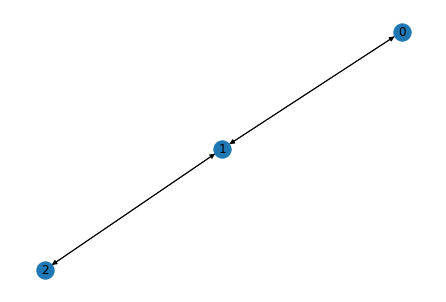

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert
from networkx import draw_kamada_kawai
import matplotlib.pyplot as plt

## 定义节点和边
# 定义节点 需要传入一个 list of list，子 list 表示节点上的特征
x = torch.tensor([[-1,1], [0,1], [1,1]], dtype=torch.float)
# 定义边 需要传入一个 list of list，第一个list是边起点的集合，第二个list是边终点的集合
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)


data = Data(x=x, edge_index=edge_index)
device = torch.device('cpu')
data = data.to(device)

for key, item in data:
    print(f'{key} found in data')

print(data['x'])

dg = convert.to_networkx(data)
draw_kamada_kawai(dg,with_labels=True)
plt.show()




# 图数据集

600
tensor([4])


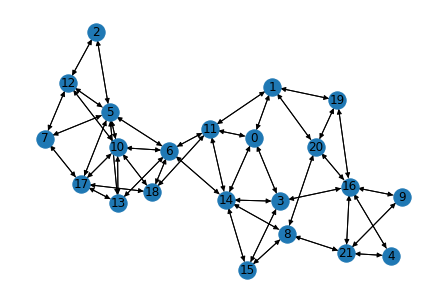

Data(edge_index=[2, 92], x=[22, 3], y=[1])


In [30]:
from torch_geometric.datasets import TUDataset
from random import randint

# ENZYMES 这个数据集有 600 张图
dataset = TUDataset(root='../data/ENZYMES', name='ENZYMES')
print(len(dataset))

# dataset 本质上是一个 list，每个位置存储一张 图
index = randint(0,600)
dg = convert.to_networkx(dataset[index])
draw_kamada_kawai(dg,with_labels=True)
plt.show()
print(dataset[index])

In [4]:
from torch_geometric.datasets import Planetoid

# Cora 这个数据集有 1 张图
dataset = Planetoid(root='../data/Cora', name='Cora')
print(len(dataset))
data = dataset[0]
print(data)


Using existing file ind.cora.x


1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


# Batch
一个 batch 就是一组图。

In [28]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='../data/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for data  in loader:
    print(data )




# Cora 这个数据集有 1 张图
dataset = Planetoid(root='../data/Cora', name='Cora')
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for data  in loader:
    print(data )


torch_geometric.datasets.tu_dataset.TUDataset
DataBatch(edge_index=[2, 4476], x=[1174, 21], y=[32], batch=[1174], ptr=[33])
DataBatch(edge_index=[2, 3810], x=[1013, 21], y=[32], batch=[1013], ptr=[33])
DataBatch(edge_index=[2, 3738], x=[947, 21], y=[32], batch=[947], ptr=[33])
DataBatch(edge_index=[2, 4230], x=[1077, 21], y=[32], batch=[1077], ptr=[33])
DataBatch(edge_index=[2, 3722], x=[1025, 21], y=[32], batch=[1025], ptr=[33])
DataBatch(edge_index=[2, 4538], x=[1211, 21], y=[32], batch=[1211], ptr=[33])
DataBatch(edge_index=[2, 4056], x=[1085, 21], y=[32], batch=[1085], ptr=[33])
DataBatch(edge_index=[2, 3884], x=[976, 21], y=[32], batch=[976], ptr=[33])
DataBatch(edge_index=[2, 3890], x=[988, 21], y=[32], batch=[988], ptr=[33])
DataBatch(edge_index=[2, 4370], x=[1208, 21], y=[32], batch=[1208], ptr=[33])
DataBatch(edge_index=[2, 3882], x=[974, 21], y=[32], batch=[974], ptr=[33])
DataBatch(edge_index=[2, 4158], x=[1112, 21], y=[32], batch=[1112], ptr=[33])
DataBatch(edge_index=[2, 4

# 自定义数据集
没必要非得弄个 dataset 类...

最终是将 Data 类输入网络进行训练，可以和 gcndemo.py 对比一下

In [6]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert
from networkx import draw_kamada_kawai
import matplotlib.pyplot as plt
## 生成数据 创建一个简单图 相邻节点相连
node_num = 10
feature_num = 3
class_num = 5
myX = torch.rand(node_num,feature_num , dtype=torch.float32)
print(myX.shape)

myY = torch.randint(class_num,(node_num,) , dtype=torch.long)


# 定义边 相邻的节点相连接
my_edge_index = torch.zeros(2,(node_num-1)*2, dtype=torch.long)
for i in range(0,(node_num-1)*2-1,2):
    # 第一条边
    ind = i//2
    my_edge_index[0,i] = ind
    my_edge_index[1,i] = ind+1
    # 第二条边
    my_edge_index[0,i+1] = ind+1
    my_edge_index[1,i+1] = ind


# for i in range(0,my_edge_index.shape[1]):
#     print(my_edge_index[:,i])

data = Data(x=myX, y=myY, edge_index=my_edge_index)

# dg = convert.to_networkx(data)
# draw_kamada_kawai(dg,with_labels=True)
# plt.show()

## 将数据存储为文件
import os
# root = '.'
# dataname = "myG"
# os.makedirs(os.path.join(root,dataname,'raw'))
# rawPath = os.path.join(root,dataname,'raw',"myG.pt")
# torch.save(data,rawPath)

torch.Size([10, 3])


In [7]:
## 用 GCN 网络进行学习
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self,feature_num,class_num):
        super().__init__()
        self.conv1 = GCNConv(feature_num, 16)
        self.conv2 = GCNConv(16, class_num)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(feature_num,class_num).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    if (epoch+1) % 100 == 0:
        print(out,data.y)
    loss.backward()
    optimizer.step()


model.eval()
pred = model(data).argmax(dim=1)
correct = (pred == data.y).sum()
acc = int(correct) / int(data.y.shape[0])
print(f'Accuracy: {acc:.4f}')



tensor([[-1.8916, -2.9160, -1.2732, -2.1069, -0.9328],
        [-1.7507, -4.0777, -1.1813, -3.1466, -0.7776],
        [-1.6905, -3.8433, -1.0695, -2.8807, -0.9292],
        [-1.7743, -3.0871, -1.5140, -1.8326, -0.9045],
        [-2.5125, -2.2162, -2.3881, -0.6770, -1.5607],
        [-3.0593, -2.0164, -3.1971, -0.4703, -1.8692],
        [-3.2964, -1.9477, -3.4573, -0.4307, -1.9748],
        [-3.9598, -1.8324, -3.7935, -0.3914, -2.1013],
        [-3.3306, -1.7670, -2.8530, -0.5581, -1.8114],
        [-2.7967, -1.8764, -2.0557, -0.7511, -1.6821]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>) tensor([2, 0, 4, 2, 3, 3, 1, 4, 3, 3], device='cuda:0')
tensor([[-1.6830, -3.4286, -0.9036, -1.9969, -1.4234],
        [-1.2320, -5.2622, -0.8134, -3.3054, -1.5001],
        [-1.4329, -4.9614, -0.8075, -3.2585, -1.3095],
        [-1.6412, -4.3627, -0.8668, -2.1074, -1.3796],
        [-2.7078, -2.8720, -1.4397, -0.7249, -1.8621],
        [-3.7545, -2.7398, -2.2397, -0.3259, -2.4812],
        [

# 绘制数据集

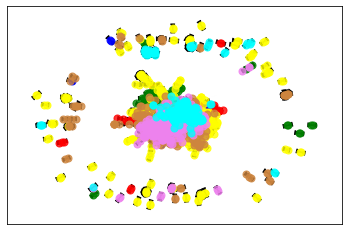

In [2]:
from torch_geometric.utils import convert
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.datasets import Planetoid

plt.figure()

dataset = Planetoid(root='../data/Cora', name='Cora')
cora = to_networkx(dataset.data)
pos = nx.layout.spring_layout(cora)


node_color = ["red","blue","green","yellow","peru","violet","cyan"] 
node_label = np.array(list(cora.nodes)) 
node_classes = dataset.data.y.data.numpy()
for i in np.arange(len(np.unique(node_classes))):
    node_list = node_label[node_classes == i]
    nx.draw_networkx_nodes(cora, pos, nodelist=list(node_list),
                           node_size=50,  
                           node_color=node_color[i], 
                           alpha=0.8)
nx.draw_networkx_edges(cora, pos,width=1,edge_color="black")

plt.show()